Load the pretrained model weights from the modular single-visit reconstruction network (multi_visit_isbi_2022) and assign them to the corresponding layers in the end-to-end network

In [1]:
import subprocess

def install(name):
    subprocess.call(['pip', 'install', name])

install('nibabel')
install('scikit-learn')

In [2]:
import numpy as np
import os
import glob
import sys
import nibabel as nib
import matplotlib.pyplot as plt

# Importing our model
MY_UTILS_PATH = "../src/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import cs_models_sc as fsnet
import tools as tools
import tensorflow as tf
# Importing callbacks and data augmentation utils

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import  Adam

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Lambda, Add, LeakyReLU,  \
                                    MaxPooling2D, concatenate, UpSampling2D,\
                                    Multiply, ZeroPadding2D, Cropping2D,    \
                                    Concatenate

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Load Training and Validation Data

In [3]:
#input paramters default (batch_size=5, string=iki, lr=1e-4, w1,w2=0.5,0.5)

channels = 2
epochs = 100
string = 'iki'
batch_size= 5
patience = 20
lr = 1e-4
decay = 1e-7
H,W = (512,512)
c1,c2 = 20,-20
w1,w2 = 0, 1
base_model_name = "../models/flat_unrolled_cascade_iki.hdf5"
model_name = "../models/end-to-end-transfer-learning-0-1-no-dc.hdf5"


In [4]:
#file ids for all training pairs and file pathes
training_files = np.loadtxt('../data/train.txt', dtype=str)
validation_files = np.loadtxt('../data/val.txt', dtype=str)
ref_path = '../../../data/brain-cancer/'
next_path = '../data/zero_filled_rec/10x/'
ref_reg_path = '../../../my-repos/multi-visit-isbi-2022/data/reference_reg_10x-iki/'

In [5]:
#pathes to training data
train_previous_files = [ref_reg_path + 'elastic_' + moving[:-4] + '_' + fixed for moving, fixed in zip(training_files[:,0],training_files[:,1])]
train_follow_up_files = [ref_path + file for file in training_files[:,1]]
train_reference_files = [ref_path + file for file in training_files[:,1]]

#pathes to validation data
val_previous_files = [ref_reg_path + 'elastic_' + moving[:-4] + '_' + fixed for moving, fixed in zip(validation_files[:,0],validation_files[:,1])]
val_follow_up_files = [ref_path + file for file in validation_files[:,1]]
val_reference_files = [ref_path + file for file in validation_files[:,1]]

In [6]:
train_kspace, train_rec, train_previous, train_ref = tools.load_data(train_follow_up_files, train_previous_files, train_reference_files)
val_kspace, val_rec, val_previous, val_ref = tools.load_data(val_follow_up_files, val_previous_files, val_reference_files)

In [7]:
#generate masks for k-space data of zero_filled reconstruction
#there may be a better way of implementing this but will try this first
# Loading sampling patterns. Notice that here we are using uncentred k-space
var_sampling_mask = np.fft.fftshift(~np.load("../data/sampling_masks/R10_512x512_poisson_center_true_radius_40_r_2.66.npy"),axes=(1,2))
var_sampling_mask = np.concatenate((var_sampling_mask[:,:,:,np.newaxis],var_sampling_mask[:,:,:,np.newaxis]),\
                               
                                   axis = -1)
# Undersampling the validation set
indexes = np.random.choice(np.arange(var_sampling_mask.shape[0],dtype =int),val_kspace.shape[0],replace = True)
val_var_sampling_mask = (var_sampling_mask[indexes])
val_kspace[val_var_sampling_mask] = 0

In [8]:
#data augmentation
seed = 905
image_datagen1 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

image_datagen2 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

image_datagen3 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

image_generator1 = image_datagen1.flow(train_rec[:,:,:,0,np.newaxis],batch_size = batch_size,seed = seed, shuffle=False)
image_generator2 = image_datagen2.flow(train_rec[:,:,:,1,np.newaxis],batch_size = batch_size,seed = seed, shuffle=False)        
image_generator3 = image_datagen3.flow(train_previous[:,:,:,0,np.newaxis],batch_size = batch_size,seed = seed, shuffle=False)        
combined = tools.combine_generator(image_generator1,image_generator2, image_generator3, var_sampling_mask)


(512, 512)
(512, 512)
(512, 512)
(512, 512)


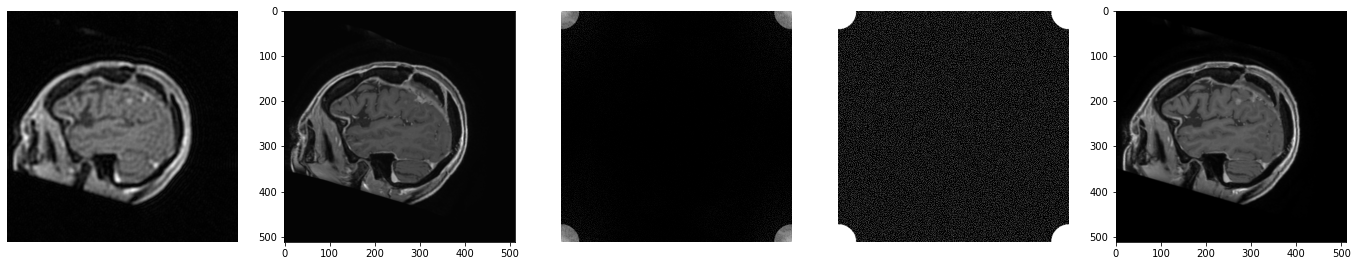

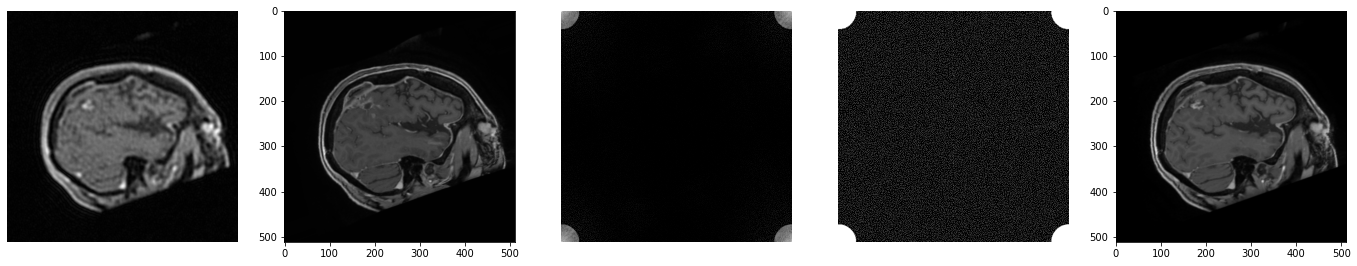

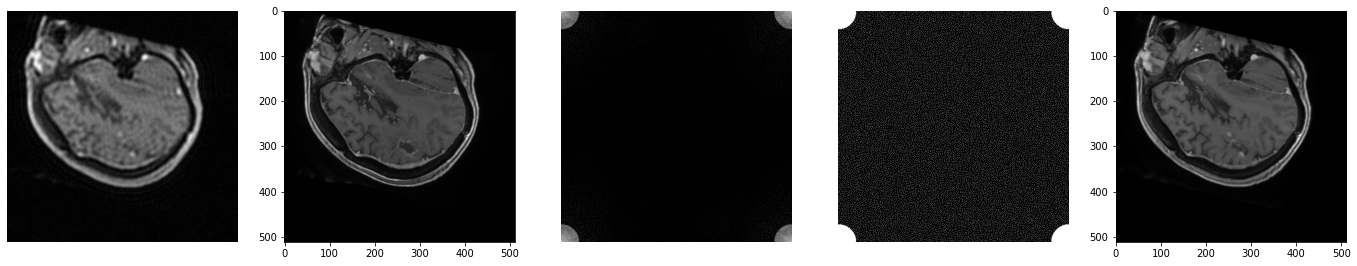

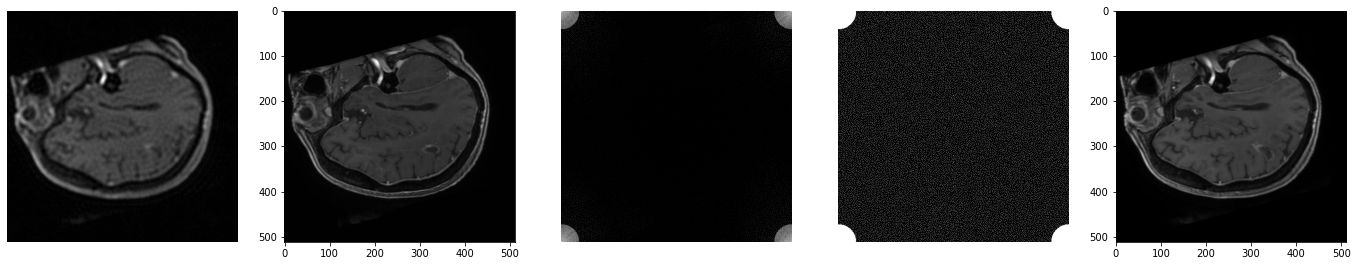

In [9]:
# Dispaly sample data augmentation
counter = 0
for ii in combined:
    
    fback = np.fft.ifft2(ii[0][0][4,:,:,0]+1j*ii[0][0][4,:,:,1])
    print(fback.shape)
    zero_filled_rec = np.abs(fback.real+1j*fback.imag)
    plt.figure(figsize=(24,10))
    #under sampled reconstruction 
    plt.subplot(151)
    plt.imshow(zero_filled_rec,cmap = 'gray')
    plt.axis("off")
    #previous scan
    plt.subplot(152)
    plt.imshow(ii[0][1][4,:,:,0], cmap='gray')
    #undersampled k-space
    plt.subplot(153)
    plt.imshow(np.log(1+np.abs(ii[0][0][4,:,:,0] + 1j*ii[0][0][4,:,:,1])),cmap = 'gray')
    plt.axis("off")
    #sampling mask
    plt.subplot(154)
    plt.imshow(ii[0][0][4,:,:,0].astype(bool),cmap = 'gray')
    plt.axis("off")
    #fully sampled reconstruction
    plt.subplot(155)
    plt.imshow(ii[1][0][4,:,:,0], cmap='gray')
    counter+=1
    if counter > 3:
        break

# Model 

In [10]:
# Early stopping callback to shut down training after
# 5 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=patience, 
                                       verbose=0, mode='min')

# Checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                         monitor='val_loss',verbose=0,\
                         save_best_only=True, save_weights_only = True)

In [11]:
#end-to-end model inputs
inputs = Input(shape=(H,W,channels))
inputs2 = Input(shape=(H,W,1))
mask = Input(shape=(H,W,channels))

# single-visit reconstruction model independently trained in modular fashion
base_model = fsnet.deep_cascade_flat_unrolled(string, H, W)
base_model.load_weights(base_model_name)

#append base model with layers for unet_block and data consistency 
x = base_model([inputs, mask], training=False)

mag = Lambda(fsnet.abs_layer)(x)
ph = Lambda(fsnet.phase_layer)(x)
x = tf.concat([mag, inputs2],-1)
x = fsnet.unet_block(x, channels=1)

out = Add()([x, mag])
out1 = fsnet.polar2cartesian(ph, out)
#out2 = fsnet.DC_block(out1, mask, inputs, channels, kspace=False)
#out3 = Lambda(fsnet.ifft_layer)(out1)
out4 = fsnet.abs_layer(out1)

model = Model(inputs=[inputs,inputs2,mask], outputs=[mag,out4])
model.layers[2].trainable = False

In [12]:
# Training our model

opt = Adam(learning_rate = lr,decay = decay)
model.compile(loss = ['mse','mse'],loss_weights=[w1,w2],optimizer=opt)
print(model.summary())

hist = model.fit(combined,
             epochs=epochs,
             steps_per_epoch=train_ref.shape[0]//batch_size,
             verbose=1,
             validation_data= ([val_kspace,val_previous,val_var_sampling_mask],[val_ref, val_ref]),
             callbacks=[checkpoint,earlyStopping])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 2) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512, 512, 2) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 512, 512, 2)  252438      input_1[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 512, 512, 1)  0           model[0][0]                

Epoch 1/100
132/132 [==============================] - 67s 449ms/step - loss: 0.0013 - lambda_5_loss: 1.1245e-04 - tf.expand_dims_1_loss: 0.0013 - val_loss: 2.2676e-04 - val_lambda_5_loss: 1.3764e-04 - val_tf.expand_dims_1_loss: 2.2676e-04
Epoch 2/100
132/132 [==============================] - 44s 337ms/step - loss: 1.4698e-04 - lambda_5_loss: 1.1249e-04 - tf.expand_dims_1_loss: 1.4698e-04 - val_loss: 1.5665e-04 - val_lambda_5_loss: 1.3764e-04 - val_tf.expand_dims_1_loss: 1.5665e-04
Epoch 3/100
132/132 [==============================] - 45s 341ms/step - loss: 1.1099e-04 - lambda_5_loss: 1.1235e-04 - tf.expand_dims_1_loss: 1.1099e-04 - val_loss: 1.2735e-04 - val_lambda_5_loss: 1.3764e-04 - val_tf.expand_dims_1_loss: 1.2735e-04
Epoch 4/100
132/132 [==============================] - 46s 347ms/step - loss: 1.0083e-04 - lambda_5_loss: 1.1234e-04 - tf.expand_dims_1_loss: 1.0083e-04 - val_loss: 1.1762e-04 - val_lambda_5_loss: 1.3764e-04 - val_tf.expand_dims_1_loss: 1.1762e-04
Epoch 5/100
132/

Epoch 34/100
132/132 [==============================] - 45s 339ms/step - loss: 7.9271e-05 - lambda_5_loss: 1.1221e-04 - tf.expand_dims_1_loss: 7.9271e-05 - val_loss: 9.5875e-05 - val_lambda_5_loss: 1.3764e-04 - val_tf.expand_dims_1_loss: 9.5875e-05
Epoch 35/100
132/132 [==============================] - 44s 334ms/step - loss: 7.8471e-05 - lambda_5_loss: 1.1208e-04 - tf.expand_dims_1_loss: 7.8471e-05 - val_loss: 9.5266e-05 - val_lambda_5_loss: 1.3764e-04 - val_tf.expand_dims_1_loss: 9.5266e-05
Epoch 36/100
132/132 [==============================] - 44s 336ms/step - loss: 7.8062e-05 - lambda_5_loss: 1.1186e-04 - tf.expand_dims_1_loss: 7.8062e-05 - val_loss: 9.6059e-05 - val_lambda_5_loss: 1.3764e-04 - val_tf.expand_dims_1_loss: 9.6059e-05
Epoch 37/100
132/132 [==============================] - 45s 344ms/step - loss: 7.8203e-05 - lambda_5_loss: 1.1186e-04 - tf.expand_dims_1_loss: 7.8203e-05 - val_loss: 9.6085e-05 - val_lambda_5_loss: 1.3764e-04 - val_tf.expand_dims_1_loss: 9.6085e-05
Epoc

Epoch 67/100
132/132 [==============================] - 45s 342ms/step - loss: 7.2537e-05 - lambda_5_loss: 1.1230e-04 - tf.expand_dims_1_loss: 7.2537e-05 - val_loss: 9.4051e-05 - val_lambda_5_loss: 1.3764e-04 - val_tf.expand_dims_1_loss: 9.4051e-05
Epoch 68/100
132/132 [==============================] - 45s 338ms/step - loss: 7.1196e-05 - lambda_5_loss: 1.1229e-04 - tf.expand_dims_1_loss: 7.1196e-05 - val_loss: 9.4982e-05 - val_lambda_5_loss: 1.3764e-04 - val_tf.expand_dims_1_loss: 9.4982e-05
Epoch 69/100
132/132 [==============================] - 44s 336ms/step - loss: 7.1437e-05 - lambda_5_loss: 1.1275e-04 - tf.expand_dims_1_loss: 7.1437e-05 - val_loss: 9.7167e-05 - val_lambda_5_loss: 1.3764e-04 - val_tf.expand_dims_1_loss: 9.7167e-05
Epoch 70/100
132/132 [==============================] - 44s 335ms/step - loss: 7.1510e-05 - lambda_5_loss: 1.1245e-04 - tf.expand_dims_1_loss: 7.1510e-05 - val_loss: 9.6475e-05 - val_lambda_5_loss: 1.3764e-04 - val_tf.expand_dims_1_loss: 9.6475e-05
Epoc

Epoch 100/100
132/132 [==============================] - 45s 343ms/step - loss: 6.8784e-05 - lambda_5_loss: 1.1242e-04 - tf.expand_dims_1_loss: 6.8784e-05 - val_loss: 8.6399e-05 - val_lambda_5_loss: 1.3764e-04 - val_tf.expand_dims_1_loss: 8.6399e-05


# Compare base model weights to end-to-end